<a href="https://colab.research.google.com/github/claudiarichardxx/Decoding-Personality-Types-from-Text-using-Myers-Briggs-Dimensions/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloning the repo

In [ ]:
%%capture
!git clone https://github.com/claudiarichardxx/Decoding-Personality-Types-from-Text-using-Myers-Briggs-Dimensions.git

In [ ]:
cd /content/Decoding-Personality-Types-from-Text-using-Myers-Briggs-Dimensions

/content/Decoding-Personality-Types-from-Text-using-Myers-Briggs-Dimensions


In [ ]:
%%capture
!pip install -r requirements.txt
from IPython.display import display, HTML
from pipeline import Pipeline

In [ ]:
from datasets import load_dataset
from utils.predict import Predictions
from utils.attributions import Attributions
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Loading dataset

In [ ]:
dataset = load_dataset("ClaudiaRichard/mbti_classification_dataset_fullPosts") #ClaudiaRichard/mbti_classification_v2
df_pandas = pd.DataFrame(dataset['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5205 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2082 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1388 [00:00<?, ? examples/s]

# Evaluation

In [ ]:
def evaluate(model_name, text, threshold = [-0.5, 0.5]):

        labs = {0: ['Introvert', 'Extrovert'], 1: ['Intuition', 'Sensing'], 2: ['Thinking', 'Feeling'], 3: ['Judging', 'Perceiving']}
        pred = Predictions()
        attribute = Attributions()
        #model = AutoModelForSequenceClassification.from_pretrained("model/bert/")
        #tokenizer = AutoTokenizer.from_pretrained("model/tokenizer/")
        pred.load_model(model_name)
        text = text.replace('|||', '[SEP]')
        encoded, labels = pred.tokenizer(text, padding = True, return_attention_mask = True, return_tensors="pt"), pred.predict_labels(text)
        attribution_th = []
        labels = list(map(int, labels))
        attribute.initialize(pred.model)
        #tokens = pred.tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
        atts = []
        for i in range(0,4):

            attributions = attribute.getAttributions(encoded, i)
            atts.append(attributions)
            #print(self.labels)
            #self.labels = list(self.labels)

            if(checkThreshold(attributions, label = int(labels[i]), threshold = threshold)):
                attribution_th.append(labels[i])
            else:
                attribution_th.append(2)

        return labels, attribution_th, atts

def checkThreshold(attributions, label, threshold = [-0.3, 0.6]):

        if(label == 0):
            if(any(attributions[0]<= threshold[0])):
                return True
            else:
                return False

        if(label == 1):
            if(any(attributions[0] >= threshold[1])):
                return True
            else:
                return False

In [ ]:
#odel_name = 'ClaudiaRichard/mbti-bert-nli-finetuned'
model_name = 'ClaudiaRichard/all-MiniLM-L12-v2_mbti_full'

In [ ]:
def formTrueLabels(first, second, third, fourth):
    return [first, second, third, fourth]

In [ ]:
df_pandas['True'] = df_pandas.apply(lambda x: formTrueLabels(x['I/E'], x['N/S'], x['T/F'], x['J/P']),axis=1)
df_pandas['raw'] = [[] for i in range(len(df_pandas))]
df_pandas['filtered'] = [[] for i in range(len(df_pandas))]
df_pandas['attributions'] = [[] for i in range(len(df_pandas))]

In [ ]:
for i in range(len(df_pandas)):
    #print(df_pandas.iloc[i]['post'])
    text = df_pandas.iloc[i]['post'][:500]
    raw, filtered, atts = evaluate(model_name, text, threshold = [-0.3, 0.6])
    print(raw)
    df_pandas.at[i, 'raw'] = raw
    df_pandas.at[i, 'filtered'] = filtered
    df_pandas.at[i, 'attributions'] = atts

In [ ]:
df_pandas.head()

,I/E,N/S,T/F,J/P,post,True,raw,filtered,attributions
0,0,0,0,0,"'Dear INTP, I enjoyed our conversation the o...","[0, 0, 0, 0]","[1, 0, 0, 0]","[1, 0, 0, 0]","[[[tensor(-0.0522, dtype=torch.float64), tenso..."
1,0,0,0,0,'I tend to build up a collection of things on ...,"[0, 0, 0, 0]","[0, 0, 0, 1]","[0, 0, 0, 1]","[[[tensor(-0.0591, dtype=torch.float64), tenso..."
2,1,0,1,0,'https://www.youtube.com/watch?v=PLAaiKvHvZs||...,"[1, 0, 1, 0]","[0, 0, 1, 1]","[0, 0, 1, 2]","[[[tensor(-0.1823, dtype=torch.float64), tenso..."
3,0,0,0,0,"'Fair enough, if that's how you want to look a...","[0, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 1, 0]","[[[tensor(-0.0953, dtype=torch.float64), tenso..."
4,1,0,1,1,"'He doesn't want to go on the trip without me,...","[1, 0, 1, 1]","[0, 0, 1, 0]","[0, 0, 1, 0]","[[[tensor(-0.1624, dtype=torch.float64), tenso..."


In [ ]:
y_true = np.array(list(df_pandas['True']))
y_pred = np.array(list(df_pandas['raw']))

labels = ["I/E", "N/S", "T/F", "J/P"]
F1s = []
conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    #tn, fp, fn, tp = confusion_matrix(y_true_label, y_pred_label).ravel()
    #print(tn, fp, fn, tp)
    print(classification_report(y_true_label, y_pred_label))
    dd = classification_report(y_true_label, y_pred_label, output_dict = True)
    F1s.append(dd['weighted avg']['f1-score'])

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1602
           1       0.55      0.29      0.38       480

    accuracy                           0.78      2082
   macro avg       0.68      0.61      0.62      2082
weighted avg       0.75      0.78      0.76      2082

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1795
           1       0.46      0.18      0.26       287

    accuracy                           0.86      2082
   macro avg       0.67      0.57      0.59      2082
weighted avg       0.82      0.86      0.83      2082

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       955
           1       0.72      0.69      0.70      1127

    accuracy                           0.69      2082
   macro avg       0.69      0.69      0.69      2082
weighted avg       0.69      0.69      0.69      2082

              preci

In [ ]:
def getF1s(df_pandas):

  y_true = np.array(list(df_pandas['True']))
  y_pred = np.array(list(df_pandas['exp']))

  labels = ["I/E", "N/S", "T/F", "J/P"]

  conf_mat_dict={}
  updated_F1s = []

  for label_col in range(len(labels)):
      y_true_label = y_true[:, label_col]
      y_pred_label = y_pred[:, label_col]
      indices = np.where(y_pred_label == 2)
      np.put(y_true_label, indices, 2)
      #y_true_label = np.delete(y_true_label, indices[0])
      #y_pred_label = np.delete(y_pred_label, indices[0])
      conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
      print(classification_report(y_true_label, y_pred_label))
      dd = classification_report(y_true_label, y_pred_label, output_dict = True)
      updated_F1s.append(dd['weighted avg']['f1-score'])

  return updated_F1s

In [ ]:
def refine(attributions, label, threshold):

  attribution_th = []
  for i in range(0,4):

            if(checkThreshold(attributions[i], label = int(label[i]), threshold = threshold)):
                attribution_th.append(label[i])
            else:
                attribution_th.append(2)

  return attribution_th

# Search for lower and upper limit

In [ ]:
ran = np.arange(-1, 0, 0.2, dtype=float)
for i in ran:
  print('Lower: ' ,i)
  df_pandas['exp'] = df_pandas.apply(lambda x: refine(x['attributions'], x['raw'], threshold = [i, 0.6]), axis=1)
  f1 = getF1s(df_pandas)
  print(f1)

Lower:  -1.0
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      1468
           1       0.47      0.10      0.16       365
           2       1.00      1.00      1.00       249

    accuracy                           0.82      2082
   macro avg       0.76      0.69      0.68      2082
weighted avg       0.78      0.82      0.77      2082

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1679
           1       0.35      0.06      0.10       229
           2       1.00      1.00      1.00       174

    accuracy                           0.88      2082
   macro avg       0.75      0.68      0.68      2082
weighted avg       0.84      0.88      0.85      2082

              precision    recall  f1-score   support

           0       0.69      0.50      0.58       589
           1       0.72      0.85      0.78       888
           2       1.00      1.00      1.00       605

    acc

In [ ]:
ran = np.arange(0, 1, 0.2, dtype=float)
for i in ran:
  print('Upper: ' ,i)
  df_pandas['exp'] = df_pandas.apply(lambda x: refine(x['attributions'], x['raw'], threshold = [-0.1, i]), axis=1)
  f1 = getF1s(df_pandas)
  print(f1)

Upper:  0.0
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1602
           1       0.55      0.29      0.38       480

    accuracy                           0.78      2082
   macro avg       0.68      0.61      0.62      2082
weighted avg       0.75      0.78      0.76      2082

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1795
           1       0.46      0.18      0.26       287

    accuracy                           0.86      2082
   macro avg       0.67      0.57      0.59      2082
weighted avg       0.82      0.86      0.83      2082

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       954
           1       0.72      0.69      0.70      1127
           2       1.00      1.00      1.00         1

    accuracy                           0.69      2082
   macro avg       0.79      0.79      0.79      2082
weighted

In [ ]:
df_pandas['exp'] = df_pandas.apply(lambda x: refine(x['attributions'], x['raw'], threshold = [-1, 0.8]), axis=1)
updated_F1s = getF1s(df_pandas)
print(updated_F1s)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1447
           1       0.45      0.04      0.08       345
           2       1.00      1.00      1.00       290

    accuracy                           0.83      2082
   macro avg       0.76      0.68      0.66      2082
weighted avg       0.78      0.83      0.77      2082

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1660
           1       0.50      0.02      0.04       221
           2       1.00      1.00      1.00       201

    accuracy                           0.89      2082
   macro avg       0.79      0.67      0.66      2082
weighted avg       0.85      0.89      0.85      2082

              precision    recall  f1-score   support

           0       0.69      0.53      0.60       552
           1       0.72      0.83      0.77       783
           2       1.00      1.00      1.00       747

    accuracy        

# Plotting before and after with threshold = [-1, 0.8]

In [ ]:
updated_F1s = [i*100 for i in updated_F1s]
F1s = [i*100 for i in F1s]

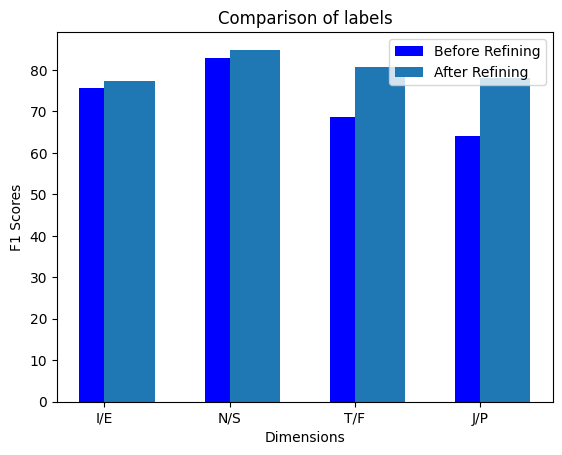

In [ ]:
import matplotlib.pyplot as plt


# X-axis values (indices)
x = range(len(F1s))

# Plotting the bars
plt.bar(x, F1s, width=0.4, label='Before Refining', align='center', color = 'blue')
plt.bar(x, updated_F1s, width=0.4, label='After Refining', align='edge')

# Adding labels and title
plt.xlabel('Dimensions')
plt.ylabel('F1 Scores')
plt.title('Comparison of labels')
plt.xticks(x, labels)

# Adding legend
plt.legend()

# Showing the plot
plt.show()